Use the VGG-19 model to do multicalss calssification task on the fetch_olivetti_faces dataset, after applying some image augmantation techniques on the dataset to increase its small size to be sufficient for the model training.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
data = fetch_olivetti_faces()
images, targets = data.images, data.target
num_classes = len(np.unique(targets))  # 40 classes

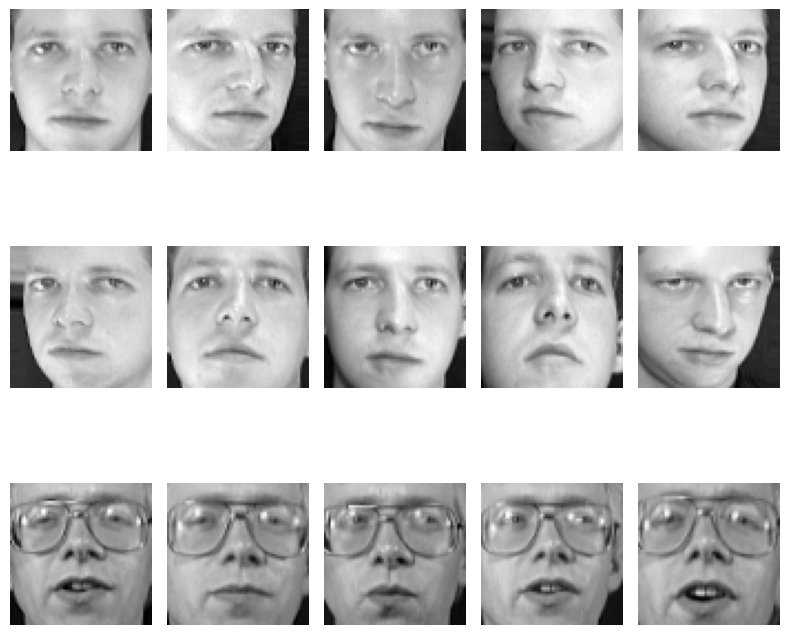

In [44]:
# Number of images to display
num_images = 15

# Create a figure and axes
fig, axes = plt.subplots(3, 5, figsize=(8, 8))  # 3 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display the images
for i in range(num_images):
    axes[i].imshow(images[i], cmap='gray')  # Display image in grayscale
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Show the plot

In [45]:
def prepare_and_preprocess(imgs):
    # Stack single channel into 3 channels
    imgs_rgb = np.stack([imgs, imgs, imgs], axis=-1)        # shape (N,64,64,3)
    # Resize to VGG19 input size
    imgs_resized = tf.image.resize(imgs_rgb, (224, 224)).numpy()
    # Convert [0,1]→[0,255] and apply VGG19 preprocessing
    return preprocess_input((imgs_resized * 255.0).astype('float32'))

X = prepare_and_preprocess(images)
y = to_categorical(targets, num_classes)

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    stratify=targets,
    random_state=42
)


In [47]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  # no augmentation on validation

batch_size = 16
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val,   y_val,   batch_size=batch_size, shuffle=False)

In [48]:
batch_size = 16
train_gen = train_datagen.flow(
    X_train, y_train, batch_size=batch_size, shuffle=True
)
val_gen = val_datagen.flow(
    X_val, y_val, batch_size=batch_size, shuffle=False
)

In [49]:
base = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False  # stage 1: freeze all conv layers

In [50]:
inputs = layers.Input(shape=(224,224,3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,044,904 (76.47 MB)

 Trainable params: 20,520 (80.16 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [51]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
ckpt = ModelCheckpoint('best_vgg19_faces_stage1.h5', monitor='val_accuracy', save_best_only=True)

In [53]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[es, ckpt],
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


20/20 - 9s - 448ms/step - accuracy: 0.0219 - loss: 9.4179 - val_accuracy: 0.0375 - val_loss: 6.7668
Epoch 2/15
20/20 - 5s - 241ms/step - accuracy: 0.0312 - loss: 8.9030 - val_accuracy: 0.0375 - val_loss: 6.3639
Epoch 3/15
20/20 - 6s - 282ms/step - accuracy: 0.0219 - loss: 8.5646 - val_accuracy: 0.0250 - val_loss: 6.0344
Epoch 4/15
20/20 - 5s - 243ms/step - accuracy: 0.0375 - loss: 8.2363 - val_accuracy: 0.0250 - val_loss: 5.7246
Epoch 5/15
20/20 - 6s - 287ms/step - accuracy: 0.0406 - loss: 8.0302 - val_accuracy: 0.0250 - val_loss: 5.4716
Epoch 6/15
20/20 - 5s - 244ms/step - accuracy: 0.0375 - loss: 7.8113 - val_accuracy: 0.0250 - val_loss: 5.2389


In [54]:
base.trainable = True
for layer in base.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
ckpt2 = ModelCheckpoint('best_vgg19_faces_stage2.h5', monitor='val_accuracy', save_best_only=True)
es2  = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[es2, ckpt2],
    verbose=2
)

Epoch 1/15


20/20 - 10s - 511ms/step - accuracy: 0.0094 - loss: 5.6675 - val_accuracy: 0.0250 - val_loss: 3.7837
Epoch 2/15


20/20 - 5s - 271ms/step - accuracy: 0.0656 - loss: 3.8388 - val_accuracy: 0.0375 - val_loss: 3.6395
Epoch 3/15


20/20 - 10s - 516ms/step - accuracy: 0.0312 - loss: 3.7197 - val_accuracy: 0.0500 - val_loss: 3.5675
Epoch 4/15


20/20 - 6s - 320ms/step - accuracy: 0.0656 - loss: 3.5296 - val_accuracy: 0.1375 - val_loss: 3.4829
Epoch 5/15


20/20 - 5s - 273ms/step - accuracy: 0.0500 - loss: 3.4664 - val_accuracy: 0.1875 - val_loss: 3.3527
Epoch 6/15


20/20 - 10s - 511ms/step - accuracy: 0.1312 - loss: 3.2382 - val_accuracy: 0.2375 - val_loss: 3.1443
Epoch 7/15


20/20 - 7s - 332ms/step - accuracy: 0.1594 - loss: 3.0885 - val_accuracy: 0.3125 - val_loss: 2.9279
Epoch 8/15


20/20 - 6s - 311ms/step - accuracy: 0.2094 - loss: 2.8467 - val_accuracy: 0.3750 - val_loss: 2.7087
Epoch 9/15


20/20 - 7s - 338ms/step - accuracy: 0.3094 - loss: 2.5687 - val_accuracy: 0.4750 - val_loss: 2.4670
Epoch 10/15


20/20 - 9s - 453ms/step - accuracy: 0.3656 - loss: 2.3638 - val_accuracy: 0.5750 - val_loss: 2.1654
Epoch 11/15


20/20 - 10s - 508ms/step - accuracy: 0.4000 - loss: 2.1017 - val_accuracy: 0.6500 - val_loss: 1.8741
Epoch 12/15


20/20 - 6s - 316ms/step - accuracy: 0.4781 - loss: 1.9395 - val_accuracy: 0.7500 - val_loss: 1.7430
Epoch 13/15


20/20 - 5s - 274ms/step - accuracy: 0.5688 - loss: 1.6532 - val_accuracy: 0.8375 - val_loss: 1.4493
Epoch 14/15


20/20 - 6s - 311ms/step - accuracy: 0.6250 - loss: 1.4380 - val_accuracy: 0.8500 - val_loss: 1.2754
Epoch 15/15


20/20 - 6s - 276ms/step - accuracy: 0.6719 - loss: 1.1989 - val_accuracy: 0.8625 - val_loss: 1.0472


<function matplotlib.pyplot.show(close=None, block=None)>

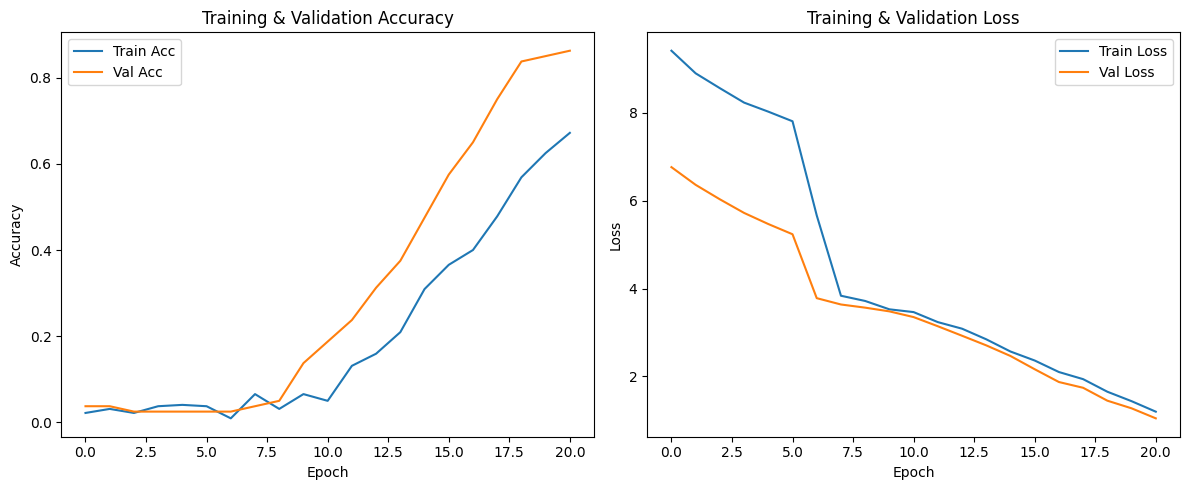

In [56]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history1.history['loss'] + history2.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'] + history2.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show